In [1]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
print(device)


n_output_mixtures = 20
n_attn_mixtures = 1
hidden_size = 128
input_size = 3
batch_size = 512
n_epochs = 1000
timestamps = 1200
lr = 1e-4
eps = 1e-6
model_name = "20210817_autoencoders"
base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
embedding_size = None # To be set to 73 later


cuda:3


In [2]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]


def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)



def draw(offsets, name=None, padding = 10, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.axis("off")
    if not name:
        plt.show()
    else:
        plt.savefig(name)
    plt.close('all')

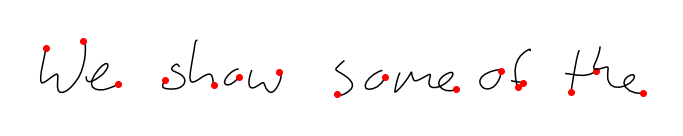

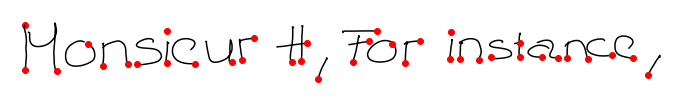

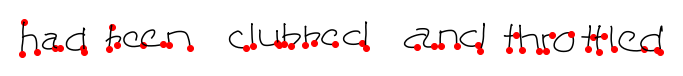

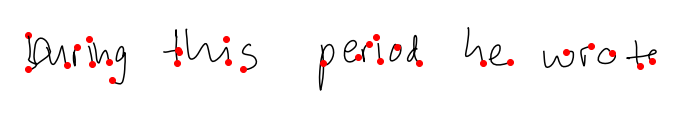

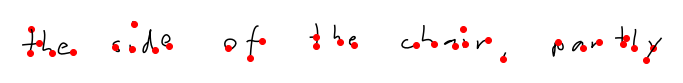

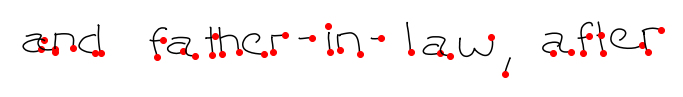

In [3]:
draw(strokes_og[23])
draw(strokes_og[230])
draw(strokes_og[231])
draw(strokes_og[223])
draw(strokes_og[123])
draw(strokes_og[233])

In [4]:
# for i in tqdm(range(len(strokes_og))):
#     draw(strokes_og[i],
#          name=f"data/images/0/{str(i)}.png",
#          padding=0,
#          plot_end_points=False)

In [5]:
! ls data/images/0/

10000.png  11533.png  2345.png	3878.png  5409.png  6941.png  8473.png
10001.png  11534.png  2346.png	3879.png  540.png   6942.png  8474.png
10002.png  11535.png  2347.png	387.png   5410.png  6943.png  8475.png
10003.png  11536.png  2348.png	3880.png  5411.png  6944.png  8476.png
10004.png  11537.png  2349.png	3881.png  5412.png  6945.png  8477.png
10005.png  11538.png  234.png	3882.png  5413.png  6946.png  8478.png
10006.png  11539.png  2350.png	3883.png  5414.png  6947.png  8479.png
10007.png  1153.png   2351.png	3884.png  5415.png  6948.png  847.png
10008.png  11540.png  2352.png	3885.png  5416.png  6949.png  8480.png
10009.png  11541.png  2353.png	3886.png  5417.png  694.png   8481.png
1000.png   11542.png  2354.png	3887.png  5418.png  6950.png  8482.png
10010.png  11543.png  2355.png	3888.png  5419.png  6951.png  8483.png
10011.png  11544.png  2356.png	3889.png  541.png   6952.png  8484.png
10012.png  11545.png  2357.png	388.png   5420.png  6953.png  8485.png
10013.png  11546.png  

In [6]:
! ls data/images/valid/0/

0.png


In [7]:
# ! mkdir data/images/0/
# ! mv data/images/* data/images/0/
# ! mkdir data/images/valid/
# ! mkdir data/images/valid/0/
# ! mv data/images/0/0.png data/images/valid/0/

(432, 864, 4)


(-0.5, 863.5, 431.5, -0.5)

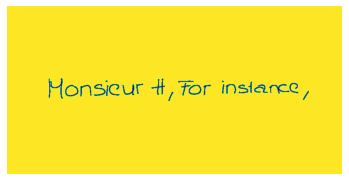

(-0.5, 863.5, 431.5, -0.5)

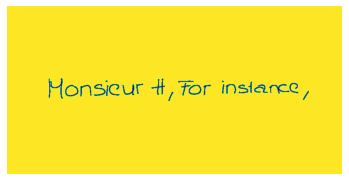

(-0.5, 863.5, 431.5, -0.5)

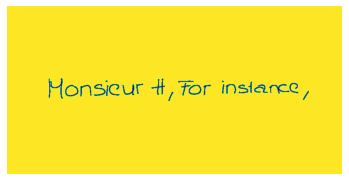

(-0.5, 863.5, 431.5, -0.5)

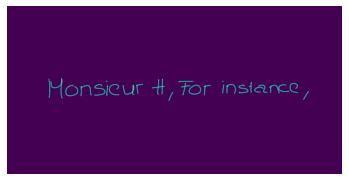

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('data/images/0/230.png')
print(img.shape)

for i in range(4):
    _=plt.imshow(img[:,:,i])
    plt.axis("off")
    plt.show()

In [9]:
for i in tqdm([23, 230, 231, 233]):
    img = mpimg.imread(f'data/images/0/{i}.png')
    print(img.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 84.85it/s]

(432, 864, 4)
(432, 864, 4)
(432, 864, 4)
(432, 864, 4)


In [10]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms



data_path = 'data/images/'
train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([
        torchvision.transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1)])
)

valid_dataset = torchvision.datasets.ImageFolder(
    root=data_path + "valid/",
    transform=transforms.Compose([
        torchvision.transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1)])
)

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=True,
    drop_last=True
)
valid_dl = DataLoader(
    valid_dataset,
    batch_size=1,
    num_workers=1,
    shuffle=True,
    drop_last=True
)

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(120, 60))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[:nmax]), nrow=2).permute(1, 2, 0))

def show_batch(batch, nmax=64):
    for images, labels in train_dl:
        print(images.shape)
        show_images(images, nmax)
        break
        


In [11]:
next(iter(valid_dataset))

(tensor([[[0.9999, 0.9999, 0.9999,  ..., 0.9999, 0.9999, 0.9999],
          [0.9999, 0.9999, 0.9999,  ..., 0.9999, 0.9999, 0.9999],
          [0.9999, 0.9999, 0.9999,  ..., 0.9999, 0.9999, 0.9999],
          ...,
          [0.9999, 0.9999, 0.9999,  ..., 0.9999, 0.9999, 0.9999],
          [0.9999, 0.9999, 0.9999,  ..., 0.9999, 0.9999, 0.9999],
          [0.9999, 0.9999, 0.9999,  ..., 0.9999, 0.9999, 0.9999]]]),
 0)

In [12]:
from einops import rearrange

class AutoEncoder(nn.Module):
    def __init__(self, width, height, channels):
        super(AutoEncoder, self).__init__()
        self.width = width
        self.height = height
        self.channels = channels
        self.npixels = width * height * channels
        
        self.encoder_hidden_layer = nn.Linear(
            in_features=self.npixels, out_features=128)
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=64)
        self.decoder_hidden_layer = nn.Linear(
            in_features=64, out_features=128)
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=self.npixels)
        
    def forward(self, x):
        out1 = rearrange(x, 'b c w h -> b (c w h)')
        out2 = torch.relu(self.encoder_hidden_layer(out1))
        out3 = torch.relu(self.encoder_output_layer(out2))
        out4 = torch.relu(self.decoder_hidden_layer(out3))
        out5 = torch.relu(self.decoder_output_layer(out4))
        out6 = rearrange(out5, 'b (c w h) -> b c w h',
                         c = self.channels, w = self.width, h = self.height)
        return out6
    
    def sample(self, valid_input):
        print("Validation")
        _= plt.imshow(valid_input.squeeze().detach().cpu().numpy())
        _=plt.show()
        out = self.forward(valid_input)
        _= plt.imshow(out.squeeze().detach().cpu().numpy())
        _=plt.show()
        print(f"validation loss: {nn.MSELoss()(valid_input, out)}")
        
        print("Random")
        with torch.no_grad():
            hidden = torch.randn(1, 64, device=device)
            out1 = torch.relu(self.decoder_hidden_layer(hidden))
            out2 = torch.relu(self.decoder_output_layer(out1))
            out2 = rearrange(out2, 'b (c w h) -> (c  w) (b h)',
                             b = 1, c = self.channels, w = self.width, h = self.height)
            _= plt.imshow(out2.detach().cpu().numpy())
            _=plt.show()
            return out2

In [13]:
print(device)

cuda:3


In [14]:
import time

load_previous_state = True

model = AutoEncoder(width=432, height=864, channels=1)
if load_previous_state:
    checkpoint = torch.load(base_dir + model_name)
    model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)

criterion = nn.MSELoss()

print_every = 25
sample_every = print_every * 10
n_iter = 0
loss = 0
losses = []
start_time = time.time()

total_iters = n_epochs * len(train_dl)


<All keys matched successfully>

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


n_iter : 0/23000, loss = 0.004509485, time_since: 10.39
Validation


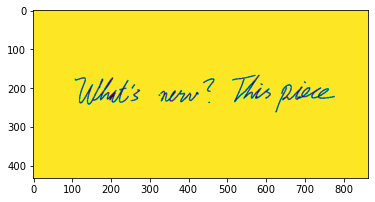

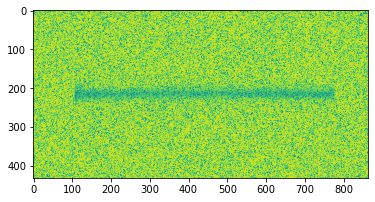

validation loss: 0.11877510696649551
Random


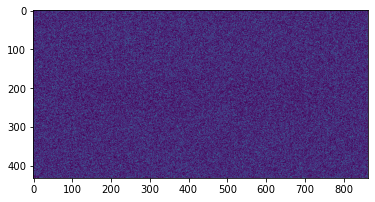

n_iter : 25/23000, loss = 0.113165015, time_since: 60.78
n_iter : 50/23000, loss = 0.112604252, time_since: 121.47
n_iter : 75/23000, loss = 0.112486281, time_since: 175.18
n_iter : 100/23000, loss = 0.112448931, time_since: 235.22
n_iter : 125/23000, loss = 0.112386382, time_since: 289.02
n_iter : 150/23000, loss = 0.112367581, time_since: 347.26
n_iter : 175/23000, loss = 0.112281228, time_since: 399.57
n_iter : 200/23000, loss = 0.112194074, time_since: 460.00
n_iter : 225/23000, loss = 0.112065751, time_since: 514.08
n_iter : 250/23000, loss = 0.111930895, time_since: 572.76
Validation


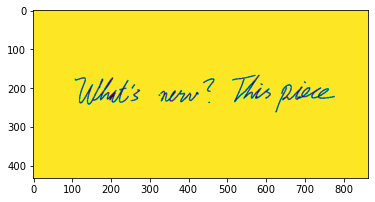

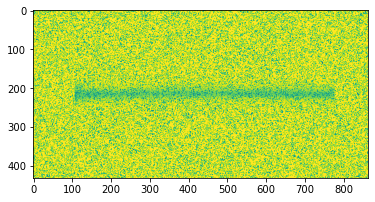

validation loss: 0.11502613127231598
Random


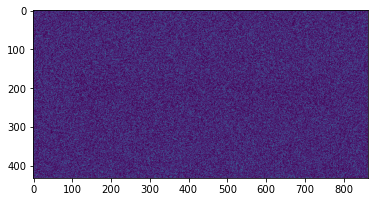

n_iter : 275/23000, loss = 0.111708387, time_since: 630.16
n_iter : 300/23000, loss = 0.111469587, time_since: 693.40
n_iter : 325/23000, loss = 0.111161220, time_since: 745.50
n_iter : 350/23000, loss = 0.110804493, time_since: 803.65
n_iter : 375/23000, loss = 0.110373467, time_since: 856.28
n_iter : 400/23000, loss = 0.109949371, time_since: 915.60
n_iter : 425/23000, loss = 0.109504577, time_since: 967.04
n_iter : 450/23000, loss = 0.109179519, time_since: 1028.91
n_iter : 475/23000, loss = 0.108900563, time_since: 1080.79
n_iter : 500/23000, loss = 0.108706726, time_since: 1139.68
Validation


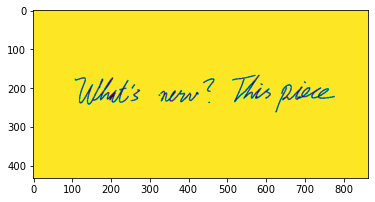

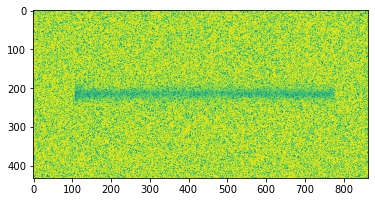

validation loss: 0.11184363812208176
Random


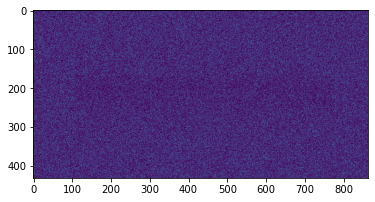

n_iter : 525/23000, loss = 0.108555829, time_since: 1192.01
n_iter : 550/23000, loss = 0.108460427, time_since: 1250.98
n_iter : 575/23000, loss = 0.108392178, time_since: 1315.26
n_iter : 600/23000, loss = 0.108333988, time_since: 1365.89
n_iter : 625/23000, loss = 0.108284666, time_since: 1425.17
n_iter : 650/23000, loss = 0.108240803, time_since: 1478.41
n_iter : 675/23000, loss = 0.108252662, time_since: 1538.75
n_iter : 700/23000, loss = 0.108228382, time_since: 1591.21
n_iter : 725/23000, loss = 0.108229098, time_since: 1650.89
n_iter : 750/23000, loss = 0.108227335, time_since: 1701.01
Validation


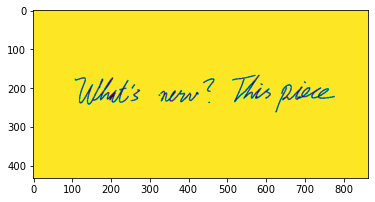

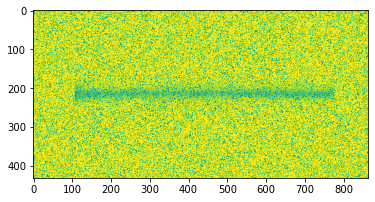

validation loss: 0.11145658046007156
Random


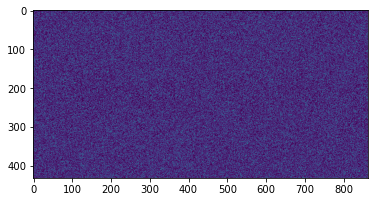

n_iter : 775/23000, loss = 0.108218695, time_since: 1759.01
n_iter : 800/23000, loss = 0.108224954, time_since: 1814.08
n_iter : 825/23000, loss = 0.108205990, time_since: 1872.94
n_iter : 850/23000, loss = 0.108219087, time_since: 1925.93
n_iter : 875/23000, loss = 0.108218592, time_since: 1989.12
n_iter : 900/23000, loss = 0.108202840, time_since: 2040.36
n_iter : 925/23000, loss = 0.108228909, time_since: 2102.13
n_iter : 950/23000, loss = 0.108212582, time_since: 2153.55
n_iter : 975/23000, loss = 0.108221874, time_since: 2214.56
n_iter : 1000/23000, loss = 0.108211709, time_since: 2266.53
Validation


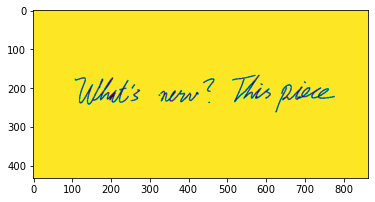

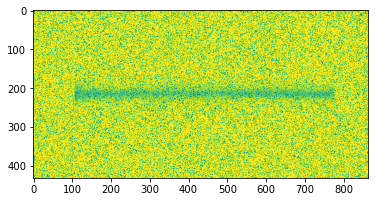

validation loss: 0.11145312339067459
Random


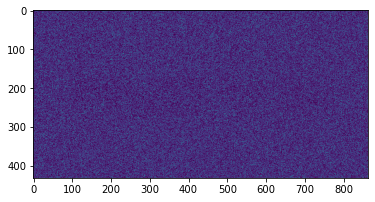

n_iter : 1025/23000, loss = 0.108211880, time_since: 2327.28
n_iter : 1050/23000, loss = 0.108224087, time_since: 2381.43
n_iter : 1075/23000, loss = 0.108207206, time_since: 2440.88
n_iter : 1100/23000, loss = 0.108220375, time_since: 2493.78
n_iter : 1125/23000, loss = 0.108200326, time_since: 2553.58
n_iter : 1150/23000, loss = 0.108205632, time_since: 2619.08
n_iter : 1175/23000, loss = 0.108205759, time_since: 2671.92
n_iter : 1200/23000, loss = 0.108200515, time_since: 2732.73
n_iter : 1225/23000, loss = 0.108204186, time_since: 2785.62
n_iter : 1250/23000, loss = 0.108180417, time_since: 2844.40
Validation


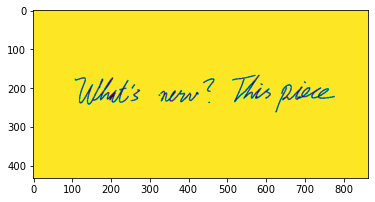

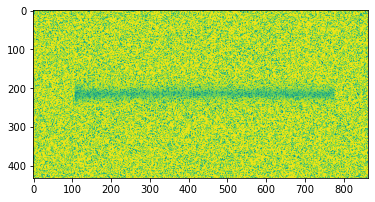

validation loss: 0.11141031235456467
Random


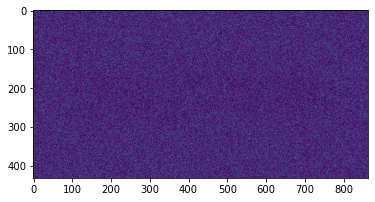

n_iter : 1275/23000, loss = 0.108198899, time_since: 2900.13
n_iter : 1300/23000, loss = 0.108170678, time_since: 2959.60
n_iter : 1325/23000, loss = 0.108190704, time_since: 3011.50
n_iter : 1350/23000, loss = 0.108177318, time_since: 3068.89
n_iter : 1375/23000, loss = 0.108171244, time_since: 3123.18
n_iter : 1400/23000, loss = 0.108185143, time_since: 3181.42
n_iter : 1425/23000, loss = 0.108187196, time_since: 3236.44
n_iter : 1450/23000, loss = 0.108173902, time_since: 3302.16
n_iter : 1475/23000, loss = 0.108182836, time_since: 3354.72
n_iter : 1500/23000, loss = 0.108178766, time_since: 3415.35
Validation


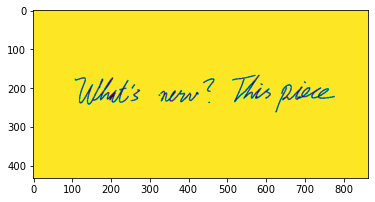

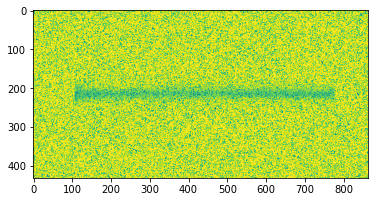

validation loss: 0.11141422390937805
Random


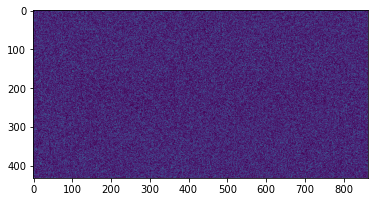

n_iter : 1525/23000, loss = 0.108198276, time_since: 3466.73
n_iter : 1550/23000, loss = 0.108171842, time_since: 3525.12
n_iter : 1575/23000, loss = 0.108170278, time_since: 3576.37
n_iter : 1600/23000, loss = 0.108182106, time_since: 3634.14
n_iter : 1625/23000, loss = 0.108180948, time_since: 3689.02
n_iter : 1650/23000, loss = 0.108175324, time_since: 3748.10
n_iter : 1675/23000, loss = 0.108176583, time_since: 3801.47
n_iter : 1700/23000, loss = 0.108169792, time_since: 3859.58
n_iter : 1725/23000, loss = 0.108171566, time_since: 3922.42
n_iter : 1750/23000, loss = 0.108173901, time_since: 3974.65
Validation


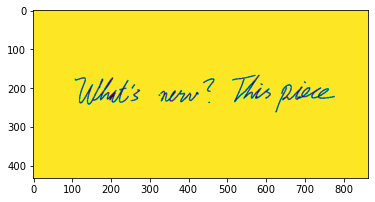

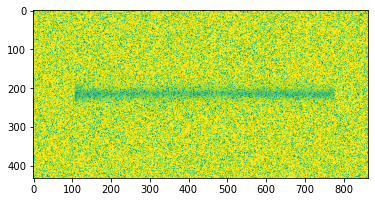

validation loss: 0.11139815300703049
Random


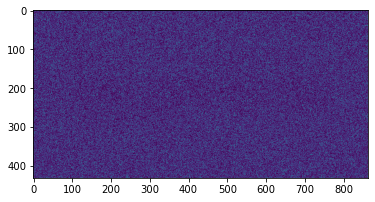

n_iter : 1775/23000, loss = 0.108168580, time_since: 4032.33
n_iter : 1800/23000, loss = 0.108169517, time_since: 4084.94
n_iter : 1825/23000, loss = 0.108179492, time_since: 4145.48
n_iter : 1850/23000, loss = 0.108144270, time_since: 4197.37
n_iter : 1875/23000, loss = 0.108136560, time_since: 4258.42
n_iter : 1900/23000, loss = 0.108079280, time_since: 4310.56
n_iter : 1925/23000, loss = 0.108058366, time_since: 4371.69
n_iter : 1950/23000, loss = 0.108018156, time_since: 4425.49
n_iter : 1975/23000, loss = 0.108017290, time_since: 4484.80
n_iter : 2000/23000, loss = 0.107999740, time_since: 4538.22
Validation


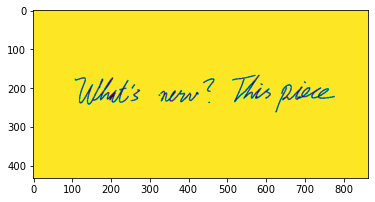

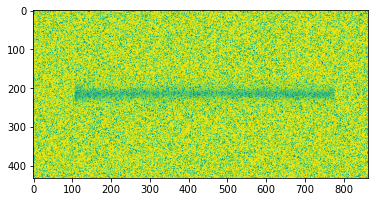

validation loss: 0.1112007200717926
Random


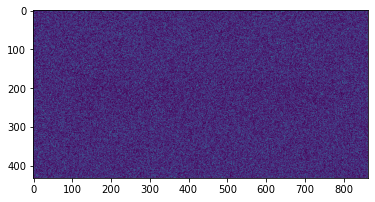

n_iter : 2025/23000, loss = 0.107988812, time_since: 4604.38
n_iter : 2050/23000, loss = 0.107984208, time_since: 4656.65
n_iter : 2075/23000, loss = 0.107950733, time_since: 4716.04
n_iter : 2100/23000, loss = 0.107955383, time_since: 4770.39
n_iter : 2125/23000, loss = 0.107948760, time_since: 4829.91
n_iter : 2150/23000, loss = 0.107962897, time_since: 4882.69
n_iter : 2175/23000, loss = 0.107955194, time_since: 4944.14
n_iter : 2200/23000, loss = 0.107935283, time_since: 4996.82
n_iter : 2225/23000, loss = 0.107950152, time_since: 5056.76
n_iter : 2250/23000, loss = 0.107963800, time_since: 5110.44
Validation


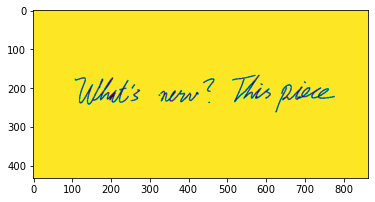

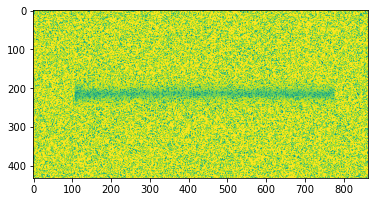

validation loss: 0.11117072403430939
Random


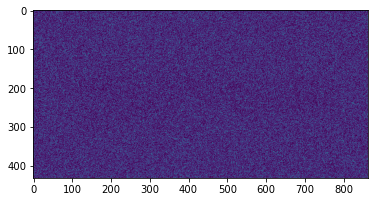

n_iter : 2275/23000, loss = 0.107915313, time_since: 5170.00
n_iter : 2300/23000, loss = 0.107899071, time_since: 5233.91
n_iter : 2325/23000, loss = 0.107901048, time_since: 5288.80
n_iter : 2350/23000, loss = 0.107885940, time_since: 5349.45
n_iter : 2375/23000, loss = 0.107901957, time_since: 5402.05
n_iter : 2400/23000, loss = 0.107895162, time_since: 5460.93
n_iter : 2425/23000, loss = 0.107910346, time_since: 5513.40
n_iter : 2450/23000, loss = 0.107891003, time_since: 5573.50
n_iter : 2475/23000, loss = 0.107855948, time_since: 5628.24


In [ ]:
def save_model(model):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    

for epoch in range(n_epochs):
    
    for batch_features, _ in train_dl:
        optimizer.zero_grad()
        batch_features = batch_features.to(device)
        outs = model(batch_features)
        train_loss = criterion(outs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
        
        if n_iter % print_every == 0:
            loss /= print_every
            losses.append(loss)
            time_since = time.time() - start_time
            print(f"n_iter : {n_iter}/{total_iters}, loss = {loss:.9f}, time_since: {time_since:.2f}")
            loss = 0
            save_model(model)
            
        if n_iter % sample_every == 0:
            for image, _ in valid_dl:
                image = image.to(device)
                _=model.sample(valid_input=image)
        
        n_iter += 1


In [ ]:
http://0.0.0.0:8082/notebooks/lyrebird_code/handwriting_synthesis/handwriting_synthesis/20210817_autoencoders.ipynb